In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append("../libraries/")
from data_loading import *
from data_extracting import *

Username: ulcidamh
········


In [3]:
#QPU connection
QLMASS = True
if QLMASS:
    try:
        from qat.qlmaas import QLMaaSConnection
        connection = QLMaaSConnection()
        LinAlg = connection.get_qpu("qat.qpus:LinAlg")
        lineal_qpu = LinAlg()
    except (ImportError, OSError) as e:
        print('Problem: usin PyLinalg')
        from qat.qpus import PyLinalg
        lineal_qpu = PyLinalg()
else:
    print('User Forces: LinAlg')
    from qat.qpus import LinAlg
    lineal_qpu = LinAlg()    

Username: ulcidamh
········


In [4]:
def draw(routine):
    program = qlm.Program()
    quantum_register = program.qalloc(routine.arity)
    program.apply(routine,quantum_register)
    global circuit
    circuit = program.to_circ()
    %qatdisplay circuit --depth 1
    del circuit


## 2. Loading Data

Typically, when we want to load some data into the quantum circuit, we will want to load a discrete probability distribution $p_d$ and an array $f$. First thing we need to define the dimension of the circuit and what we want to load. Here $n$ is the number of qubits and $N = 2^n$ is the size of the discretized probability distribution and the size of the array. In this specific example $n = 3$ and $N = 8$.

In [5]:
n = 3
N = 2**n
x = np.arange(N)

Next, we define a discrete probability distribution:

$$p_d = \left(p_0,p_1,p_2,p_3,p_4,p_5,p_6,p_7\right).$$

In this specific example we are going to generate the following probability distribution:

$$p_d = \dfrac{1}{0+1+2+3+4+5+6+7}\left(0,1,2,3,4,5,6,7\right),$$
which is saved in the variable *probability*.

In [6]:
probability = x/np.sum(x)

Finally we define an array:
$$f = \left(f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7\right).$$
Later, it will become useful to have a normalised version of this function that we will call $\hat{f}$. This new function $\hat{f}$ has the main characteristic that where the maximum absolute value of the function is one $||\hat{f}||_{\infty} = 1$:
$$\hat{f} = \dfrac{f}{||f||_{\infty}} = \left(\hat{f}_0,\hat{f}_1,\hat{f}_2,\hat{f}_3,\hat{f}_4,\hat{f}_5,\hat{f}_6,\hat{f}_7\right).$$
In the code, this is the reason why we introduce the variable *normalization_constant* $=||f||_{\infty}$.

In this specific example we choose $f$ to simply be:
$$f = \left(0,1,2,3,4,5,6,7\right).$$
Hence, $\hat{f}$ is:
$$\hat{f} = \dfrac{f}{||f||_{\infty}} = \dfrac{1}{7}\left(0,1,2,3,4,5,6,7\right).$$


In [7]:
normalization_constant = np.max(x)
f = x
f_normalised = x/normalization_constant

### 1.1 Loading Probability

To load a discrete probability distribution we just need the function **load_probability**, which inside the **data_loading** module. The input should be a numpy array with the probability distribution that we want to load into the quantum state. In this case the probability distribution is the variable *probability*. The output of the function is a **qlm** *AbstractGate* with arity *n*. 

In [8]:
routine = load_probability(probability)

Now, our quantum state has the form:
$$\left[\sqrt{p_0}|0\rangle+\sqrt{p_1}|1\rangle+\sqrt{p_2}|2\rangle+\sqrt{p_3}|3\rangle+\sqrt{p_4}|4\rangle+\sqrt{p_5}|5\rangle+\sqrt{p_6}|6\rangle+\sqrt{p_7}|7\rangle\right]$$
The corresponding circuit can be visualized directly passing the qlm routine *routine* to the function *draw*.

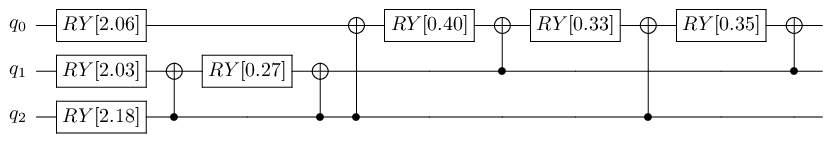

In [9]:
draw(routine)

Last, we use the function *measure_probabilities* to obtain the probabilities loaded into the quantum circuit. By the quantum properties, what we are measuring is:
$$\left(\sqrt{p_0}^2,\sqrt{p_1}^2,\sqrt{p_2}^2,\sqrt{p_3}^2,\sqrt{p_4}^2,\sqrt{p_5}^2,\sqrt{p_6}^2,\sqrt{p_7}^2\right) = \left(p_0,p_1,p_2,p_3,p_4,p_5,p_6,p_7\right)$$

In [10]:
quantum_probabilities = measure_probabilities(routine)
print("Quantum probabilities: ",quantum_probabilities)
print("Classical probabilities: ",probability)

Submitted a new batch: Job5330


KeyboardInterrupt: 

In order to work properly, the function *load_probabilities* has to be the first gate of the whole circuit.

### 1.2 Loading Function

To load an array we need more steps than in the previous example. We first need to load a probability distribution in the state and reserve an extra qubit for loading the function. Here we don't want to focus on the part of loading a probability distribution as it has been already treated in the previous subsection, for that reason we will simply call the function *uniform_distribution*.

In [11]:
routine = QRoutine()
register = routine.new_wires(n+1)
routine.apply(uniform_distribution(n),register[:n])

Our circuit has the form:

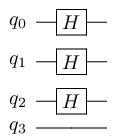

In [12]:
draw(routine)

And the state now loaded in the circuit is:
$$\dfrac{1}{\sqrt{N}}|0\rangle\left[|0\rangle+|1\rangle+|2\rangle+|3\rangle+|4\rangle+|5\rangle+|6\rangle+|7\rangle\right]$$
The next step is loading our function. For that purpose we need to compute the associated angles:
$$ \left(\theta_0,\theta_1,\theta_2,\theta_3,\theta_4,\theta_5,\theta_6,\theta_7\right)= \theta =2\arccos\left(\hat{f}\right)=\left(2\arccos\left(\hat{f}_0\right),2\arccos\left(\hat{f}_1\right),2\arccos\left(\hat{f}_2\right),2\arccos\left(\hat{f}_3\right),2\arccos\left(\hat{f}_4\right),2\arccos\left(\hat{f}_5\right),2\arccos\left(\hat{f}_6\right),2\arccos\left(\hat{f}_7\right)\right)$$
This is the reason why we need to work with the normalised version of function $f$.

In [13]:
angles = 2*np.arccos(f_normalised)

To load an array we will use the function **load_angles**, which inside the **data_loading** module. The input should be a numpy array with the angles asociated to the normalised function $\hat{f}$. In this case the probability distribution is the variable *probability*. The output of the function is a **qlm** *AbstractGate* with arity *n*.

Next, we load the angles into the quantum state. For that we have the function *load_angles*, these function admits a second argument called *method*. By default it is set to *multiplexors*, but it can also have the value *brute_force*. The second option is much less efficient in terms of quantum gates.

In [14]:
routine.apply(load_angles(angles),register)

Now, our quantum state has the form:
$$\dfrac{1}{\sqrt{N}}|0\rangle\left[\cos\left(\dfrac{\theta_0}{2}\right)|0\rangle+\cos\left(\dfrac{\theta_1}{2}\right)|1\rangle+\cos\left(\dfrac{\theta_2}{2}\right)|2\rangle+\cos\left(\dfrac{\theta_3}{2}\right)|3\rangle+\cos\left(\dfrac{\theta_4}{2}\right)|4\rangle+\cos\left(\dfrac{\theta_5}{2}\right)|5\rangle+\cos\left(\dfrac{\theta_6}{2}\right)|6\rangle+\cos\left(\dfrac{\theta_7}{2}\right)|7\rangle\right]+...,$$
substituting the value of the angles we have the state
$$\dfrac{1}{\sqrt{N}}|0\rangle\left[\hat{f}_0|0\rangle+\hat{f}_1|1\rangle+\hat{f}_2|2\rangle+\hat{f}_3|3\rangle+\hat{f}_4|4\rangle+\hat{f}_5|5\rangle+\hat{f}_6|6\rangle+\hat{f}_7|7\rangle\right]+...$$
The associated circuit is:

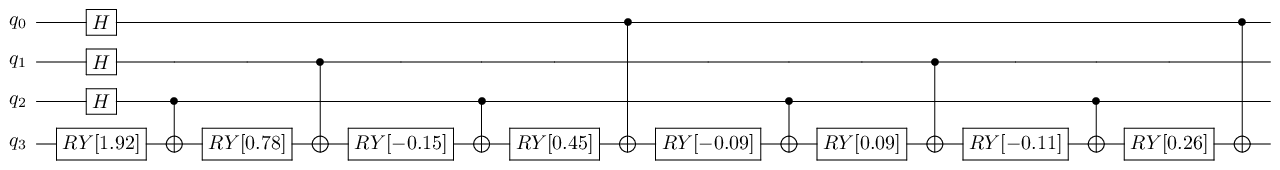

In [15]:
draw(routine)

Finally, we measure the probabilities that we have loaded.

In [17]:
quantum_probabilities = measure_probabilities(routine)

QPUException: QPUException(code=15, modulename='qat.resourcemanager', message='Not enough resources for this job.  Please consider reducing some parameter to fit in available resource.', file=None, line=None)

By the quantum properties, the result stored in the variable *quantum_probabilities* is the absolute value of the square of $\hat{f}$ divided by $N$, that is:
$$p = \dfrac{1}{N}\left(\hat{f}_0^2,\hat{f}_1^2,\hat{f}_2^2,\hat{f}_3^2,\hat{f}_4^2,\hat{f}_5^2,\hat{f}_6^2,\hat{f}_7^2,...\right)$$
There is more information stored in the variable, but we don't need it.

If we want to recover the function $f$ we need to compute the square root of the probabilities and multiplicate by $N$ and by the normalization constant:
$$f_i = N||f||_{\infty}\sqrt{p_i}$$

In [18]:
quantum_f = np.sqrt(quantum_probabilities)*np.sqrt(N)*normalization_constant
print("Array loaded in the quantum state: ",quantum_f[:N])
print("Original array: ",f)


NameError: name 'quantum_probabilities' is not defined

### 2.3 Loading a function upon a non trivial probability distribution

Now we are going to load a discrete probability distribution $p_d$ and an array $f$ altogether. This case is a combination of the two previous cases. First we start by loading the discrete probability distribution $p_d$. Note that, for loading the normalised array $\hat{f}$ we need an extra qubit. The probability function is loaded just in the first three registers: 


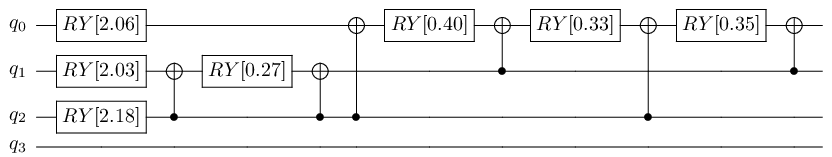

In [92]:
routine = QRoutine()
register = routine.new_wires(n+1)
routine.apply(load_probability(probability),register[:n])
draw(routine)

Now our quantum state is:
$$|0\rangle\left[\sqrt{p_0}|0\rangle+\sqrt{p_1}|1\rangle+\sqrt{p_2}|2\rangle+\sqrt{p_3}|3\rangle+\sqrt{p_4}|4\rangle+\sqrt{p_5}|5\rangle+\sqrt{p_6}|6\rangle+\sqrt{p_7}|7\rangle\right]$$

Next we compute the angles and load the function. Instead of loading $\hat{f}$ we are going to load $\sqrt{\hat{f}}$ to have everything in the same pace.

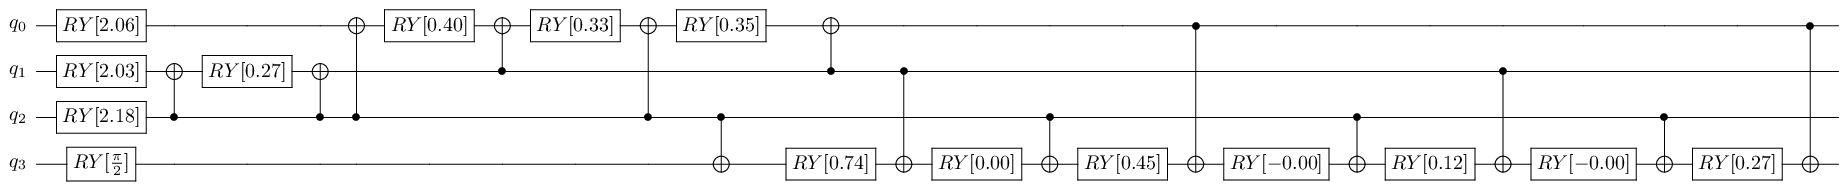

In [93]:
f_root = np.sqrt(f_normalised)
angles = 2*np.arccos(f_root)
routine.apply(load_angles(angles),register)
draw(routine)

Now our quantum state is:
$$|0\rangle\left[\sqrt{p_0\hat{f}_0}|0\rangle+\sqrt{p_1\hat{f}_1}|1\rangle+\sqrt{p_2\hat{f}_2}|2\rangle+\sqrt{p_3\hat{f}_3}|3\rangle+\sqrt{p_4\hat{f}_4}|4\rangle+\sqrt{p_5\hat{f}_5}|5\rangle+\sqrt{p_6\hat{f}_6}|6\rangle+\sqrt{p_7\hat{f}_7}|7\rangle\right]+...$$
If we measure again, we can compare our result with the element-wise product of $p_d$ and $f$

In [94]:
quantum_result = measure_probabilities(routine)*normalization_constant
print("Quantum result: ",quantum_result[0:N])
print("Classical result: ",probability*f)

Quantum result:  [0.         0.03571429 0.14285714 0.32142857 0.57142857 0.89285714
 1.28571429 1.75      ]
Classical result:  [0.         0.03571429 0.14285714 0.32142857 0.57142857 0.89285714
 1.28571429 1.75      ]


If we wanted to compute the scalar product from the previous technique, we can use a neat trick. If we just measure the last qubit (the one that is more on the left in the state or the one that is at the bottom in the circuit) we are effectively computing this amount:

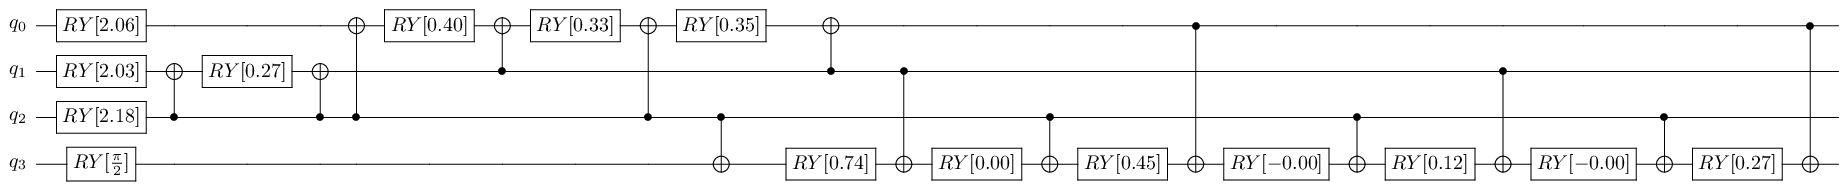

In [110]:
program = qlm.Program()
qubits = program.qalloc(n+1)
program.apply(routine,qubits)
circuit = program.to_circ()
%qatdisplay circuit

In [123]:
job = circuit.to_job(qubits=[n])
linalg_qpu = LinAlg()
result = linalg_qpu.submit(job)
if not isinstance(result,Result):
    result = result.join()

    # Result
result_array = np.zeros(2)
for sample in result:
    result_array[sample.state.lsb_int] = sample.probability
print("Quantum result: ",result_array[0]*normalization_constant)
print("Classical result: ",np.dot(probability,f))

Quantum result:  4.999999999999999
Classical result:  5.0


## 2.4 Loading two arrays

In our final example we are going to load two arrays $f$ and $g = p_d$. To load two arrays we need two extra qubits, one for the first array and another for the second one. We start again by defining our base routine with size $n+2$. As we always need to load a base distribution we load a uniform probability distribution.

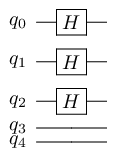

In [83]:
g = probability
routine = QRoutine()
register = routine.new_wires(n+2)
routine.apply(uniform_distribution(n),register[:n])
draw(routine)

We already have defined the normalised version of $f$, $\hat{f}$ which is stored in the variable *f_normalised*. But the discrete probability distribution $p_d$ is not normalised. For this reason we define the normalised version as:
$$\hat{g} = \dfrac{g}{||g||_{\infty}}.$$

In [84]:
g_normalised = g/np.max(g)

Next, we have to compute the associated angles for $\hat{f}$ and $\hat{g}$:
$$\theta_f = 2\arccos\left(\hat{f}\right),$$
$$\theta_g = 2\arccos\left(\hat{g}\right).$$

In [86]:
theta_f = 2*np.arccos(f_normalised)
theta_g = 2*np.arccos(g_normalised)

Now we have to load the angles into the circuit. Because we have two functions instead of one, we are going to load the first function in the first reserved register and the second one in the second reserved register.

In [87]:
routine.apply(load_angles(theta_f),register[0:n],register[n])
routine.apply(load_angles(theta_g),register[0:n],register[n+1])
draw(routine)

Now our quantum state is:
$$\dfrac{1}{\sqrt{N}}|0\rangle|0\rangle\left[f_0 g_0|0\rangle+f_1 g_1|1\rangle+f_2 g_2|2\rangle+f_3 g_3|3\rangle+f_4 g_4|4\rangle+f_5 g_5|5\rangle+f_6 g_6|6\rangle+f_7 g_7|7\rangle\right]+...$$
If we measure again, we can compare our result with the element-wise product of $g$ and $f$

In [124]:
quantum_result = np.sqrt(measure_probabilities(routine)*N)*np.max(f)*np.max(g)
classical_result = f*g
print("Quantum result: ",quantum_result[:N])
print("Classical result: ",classical_result)

Quantum result:  [0.         0.35355339 0.70710678 1.06066017 1.41421356 1.76776695
 2.12132034 2.47487373]
Classical result:  [0.         0.03571429 0.14285714 0.32142857 0.57142857 0.89285714
 1.28571429 1.75      ]


If we want to compute the scalar product from our state we simply need to do a Hadamard transform. The first coefficient of the Hadamard transform is the sum of input vector, in other words, our previous state:

$$\dfrac{1}{\sqrt{N}}|0\rangle|0\rangle\left[f_0 g_0|0\rangle+f_1 g_1|1\rangle+f_2 g_2|2\rangle+f_3 g_3|3\rangle+f_4 g_4|4\rangle+f_5 g_5|5\rangle+f_6 g_6|6\rangle+f_7 g_7|7\rangle\right]+...,$$
transforms to:
$$\dfrac{1}{N}|0\rangle|0\rangle\left[f_0 g_0+f_1 g_1+f_2 g_2+f_3 g_3+f_4 g_4+f_5 g_5+f_6 g_6+f_7 g_7\right|0\rangle+...]+...$$
The rest of the coefficients depend on which specific transformation we are doing, as there are three different versions of this transform

## Appendix: Quantum Multiplexors

Implementation of loading data routines using the *Lov Grover and Terry Rudolph* routines directly, using controlled rotations by state, is highly inneficient. In general the use of controlled rotations generate highly deep quantum circuits prone to errors. 
A more efficient approach is the use of Quantum Multiplexors where the only controlled gates are c-Not ones. 

The operation we want to implement is a controlled rotation on an angle $\theta_i$ controlled by a state $|i\rangle$. 

For a 2 qbits state the operator should be:

$$
\hat{U}|q_1q_0\rangle= \{ \begin{array}{ll}
      \hat{R}_y(\theta_0)|0\rangle|q_0\rangle  & if \;|q_0\rangle = |0\rangle \\
      \hat{R}_y(\theta_1)|0\rangle|q_0\rangle  & if \;|q_0\rangle = |1\rangle \\
\end{array}
$$

With a quantum multiplexor this operation can be implemented as:

$$\hat{U}(\theta_0, \theta_1)|q_1q_0\rangle= \left( \mathbf{I} \otimes \hat{R}_{y} \left(\frac{\theta_0+\theta_1}{2}\right) \right) \hat{C}_{NOT} \left(\mathbf{I} \otimes \hat{R}_{y} \left(\frac{\theta_0-\theta_1}{2}\right) \right) \hat{C}_{NOT}|q_1q_0\rangle$$

The circuit representation for this operator is:

![alt text](./QM_01.png)

As can be seen the quantum multiplexor needs only $C_{NOT}$ gates that are implemented in easier way than controlled rotations


For controlled state rotations of more angles quantum multiplexors can be implemented in a recursively way. For example if we want apply a controlled 4 angle rotation $[\theta_0, \theta_1, \theta_2, \theta_3]$ we can use following circuit:

![alt text](./QM_02.png)


In general a quantum multiplexor with $m$ control qubits can be decomposed as 2 multiplexors with $m − 1$ control qubits and 2 $\hat{C}_{NOT}$ gates:
![alt text](./QM_03.png)

In the **QuantumMultiplexors_Module** there are an implementation for a quantum multiplexor controlled by $m$ qbits and the functions neede to use them in order to load probability and a Integral function